# Neural Network for Variation Problem

## Brachistochrone Curve

For reference, c.f. [here](https://baike.baidu.com/item/%E6%9C%80%E9%80%9F%E9%99%8D%E7%BA%BF%E9%97%AE%E9%A2%98).

For a trajectory $y(x)$ for $\forall x \in [0, 1]$, the action (loss), as the total time spent, is given by
$$ \mathcal{L}[y] = \int_0^1 d x \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x) } } { \sqrt{- 2 g y(x)} } , $$
with boundary condition
$$ y(0) = 0 \;, y(1) = -1 , $$
where $g$ is the gravitational constant. Ensure that $y(x) \le 0, \forall x \in [0, 1]$.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import datetime
from collections import namedtuple

/Users/shuiruge/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Employ Monte-Carlo approximation. Let $\{ x_i: i = 1, \ldots, N \} \sim \text{Uniform}(0, 1)$, the action with boundary condition and penalty becomes
$$
  \mathcal{L}[y] = \frac{1}{N} \sum_{i=1}^{N} \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x_i) } } { \sqrt{-2 g y(x_i)} }
       + \frac{\lambda}{2} \sum_{ x_b \in \{0,1\} } d(y(x_b), 0), 
$$
with some adjustable hyper-parameter $\lambda \in \mathbb{R}^+$ and some pre-defined distance $d$.

In [2]:
# -- Helpers

def l1_norm(x):
    """L1-norm."""
    return np.mean(np.abs(x))

def flatten(nested_list):
    """Helper. (Recursively) flatten an arbitrarily nested list."""
    if nested_list == []:
        return nested_list
    if isinstance(nested_list[0], list):
        return flatten(nested_list[0]) + flatten(nested_list[1:])
    return nested_list[:1] + flatten(nested_list[1:])

In [3]:
def make_neural_network(x, hidden_layers, output_shape, name=None):
  """Implement the neural network with dense hidden layers, each with
  the same activation-function `activation`, and regularized by a
  dropout layer with dropout-rate as the default (i.e. 0.5).
  Args:
    x: Tensor-like, as the input of the neural network. It's shape is
        of `[batch_size] + x_shape`.
    hidden_layers: List of objects of the classes in `tf.layers`.
    output_shape: List of integers.
  Returns:
    The output tensor of the neural network.
  """
  x = tf.convert_to_tensor(x, name='x')

  with tf.name_scope(name, 'NeuralNetwork', [x]):
    
    # Hidden layers
    hidden = x  # initialize.
    for layer in hidden_layers:
      hidden = layer(hidden)
    
    # Output layer
    flatten_hidden = tf.layers.flatten(hidden)
    output_size = sum(flatten(output_shape))
    output = tf.layers.dense(flatten_hidden, output_size)
    output = tf.reshape(output, [-1]+output_shape)

  return output

In [10]:
def action(y, grad_y, g=9.8, epsilon=1e-8, name=None):
    """Implements the action.
    Args:
      y: Tensor-like, with shape `[batch_size] + y_shape`.
      grad_y: Tensor-like, with shape `[batch_size] + y_shape`.
    Returns:
      Scalar.
    """
    y = tf.convert_to_tensor(y, name='y')
    grad_y = tf.convert_to_tensor(grad_y, name='grad_y')
    with tf.name_scope(name, 'Action', [y, grad_y]):
      delta_height = tf.where(y < 0.0, y, tf.zeros(y.shape))
      lagrangians = tf.truediv(
          tf.sqrt(1.0 + tf.square(grad_y)),
          tf.sqrt(- 2.0 * g * delta_height + epsilon))
      return tf.reduce_mean(lagrangians)
    
    
def make_distance(x, y, name=None):
  """Mean square distance between tensors `x` and `y`."""
  with tf.name_scope(name, 'MeanSquareDistance', [x, y]):
    distance = tf.reduce_mean(tf.square(x - y))
  return distance


LossOps = namedtuple('LossOps',
    'loss, y, grad_y, y_within, y_boundary, action_part, boundary_part')

def make_loss(x_within, x_boundary, make_neural_network,
              lambda_=10.0, name=None):
  """Implements the loss.
  Args:
    x_within: Tensor-like, with shape `[batch_size] + x_shape`, as the
        non-boundary values of the input to the neural network.
    x_boundary: Tensor-like, with shape `[n_boundaries] + x_shape`, as
        the boundary values of the input to the neural network.
    make_neural_network: Callable that maps `x` to the neural network
        output.
    lambda_: Float, as the $lambda$ in the formula of loss.
  Returns:
    Scalar, as the loss.
  """
  x_within = tf.convert_to_tensor(x_within, name='x_within')
  x_boundary = tf.convert_to_tensor(x_boundary, name='x_boundary')
    
  x = tf.concat([x_within, x_boundary], axis=0)    
  y = make_neural_network(x)    

  batch_size = x_within.get_shape().as_list()[0]
  n_boundary = x_boundary.get_shape().as_list()[0]
  y_within, y_boundary = tf.split(y, [batch_size, n_boundary],
                                  axis=0)
  grad_y = tf.gradients(y, [x])[0]

  with tf.name_scope(name, 'Loss'):
    lambda_ = tf.constant(lambda_, dtype='float32')
    action_part = action(y, grad_y)
    boundary = tf.constant([[0.0], [-1.0]], dtype='float32')
    boundary_part = lambda_ * make_distance(y_boundary, boundary)
    #loss = action_part + boundary_part
    loss = action_part * (1.0 + boundary_part)  # for arbitrary choice.

  return LossOps(loss, y, grad_y, y_within, y_boundary,
                 action_part, boundary_part)

In [13]:
%%time
tf.reset_default_graph()

x_dim = 1
n_samples = 100
y_dim = 1

with tf.name_scope('X'):
    x_within = tf.placeholder(shape=[n_samples, x_dim], dtype='float32',
                              name='x_within')
    x_boundary = tf.constant([[0.0], [1.0]], dtype='float32',
                             name='x_boundary')
    
with tf.name_scope('HiddenLayers'):
    hidden_layers = []
    for i in range(3):
        hidden_layers += [
            lambda x: tf.layers.dense(
                x, 10, activation=tf.tanh),
        ]

ops = make_loss(
    x_within, x_boundary,
    lambda x: make_neural_network(x, hidden_layers, [y_dim]))

# For optimizing
#optimizer = tf.train.AdamOptimizer(0.003)
optimizer = tf.train.RMSPropOptimizer(0.001)
train_op = optimizer.minimize(ops.loss)

# For logging
tf.summary.scalar('loss', ops.loss)
summary_op = tf.summary.merge_all()

with tf.Session() as sess:

    # -- Initializing
    # For logging
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = tf.summary.FileWriter('../dat/logdir/'+ current_time, sess.graph)
    # Initialize all `tf.Variable`s, explicit or implicit
    sess.run(tf.global_variables_initializer())

    # -- Optimizing

    # Parameters
    n_iters = 3*10**4

    def get_x_within_value():
        x_within_value = np.array(
            [[np.random.random()] for _ in range(n_samples)],
            dtype='float32')
        return x_within_value

    # Iterations
    for step in range(n_iters):
        iter_ops = [train_op, summary_op, ops.loss, ops.y,
                    ops.grad_y, ops.action_part, ops.boundary_part]
        feed_dict = {x_within: get_x_within_value()}
        result = sess.run(iter_ops, feed_dict=feed_dict)
        _, summary, loss, y, grad_y, action_part, boundary_part = result
        
        # Logging
        if (step+1) % 1000 == 0:
            writer.add_summary(summary, step)
            print(step, loss, action_part, boundary_part,
                  l1_norm(grad_y), l1_norm(y))

    # Return the predict-values of the trained neural network
    x_within_value = np.linspace(0, 1, n_samples, dtype='float32')
    x_within_value = np.expand_dims(x_within_value, axis=1)
    y_within_value = sess.run(
        ops.y_within,
        feed_dict={x_within: x_within_value})

999 0.04355839 0.038527656 0.1305746 0.76908207 0.6913086
1999 0.045779802 0.040536623 0.12934428 0.8419569 0.6736935
2999 0.048642766 0.043325126 0.122738004 0.8448847 0.6536078
3999 0.045981202 0.04194278 0.09628419 0.8252311 0.6803117
4999 0.045085672 0.040301513 0.11870916 0.80086285 0.69019115
5999 0.04788639 0.04256551 0.12500459 0.8496915 0.65149385
6999 0.04712753 0.04245318 0.11010593 0.836831 0.6522537
7999 0.047451507 0.042858552 0.107165486 0.8612525 0.66450405
8999 0.046011124 0.041218612 0.11627051 0.8183442 0.6688345
9999 0.045831148 0.041181028 0.112919 0.81563914 0.67740774
10999 0.04245396 0.037521888 0.13144514 0.74842334 0.71747524
11999 0.050631072 0.045377344 0.11577874 0.8772215 0.6644028
12999 0.043447603 0.038732864 0.12172447 0.7745048 0.7077995
13999 0.04656018 0.04118002 0.13064976 0.8172074 0.67846626
14999 0.045626003 0.041313544 0.10438368 0.8438574 0.6776878
15999 0.045961544 0.040608972 0.13180761 0.7789778 0.6857242
16999 0.043645754 0.038665578 0.1288

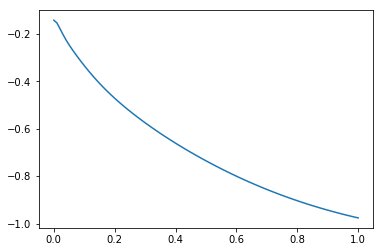

In [14]:
# Visualization
plt.plot(x_within_value, y_within_value)